<center> ![alt text](http://i63.tinypic.com/352kyeb.jpg)<center>



 #  $   Tracking~Methods  $
 
  # $ \displaystyle Meanshift,~Camshift~and~Kalman~filters$
  

### What is object tracking ?
  Simply put,it is the process of locating a moving object (or multiple objects) over time using a camera.
  
  ### Why study object tracking ?
   Object tracking is useful in a variety of applications,such as human-computer interaction, security and surveillance , medical imaging,augmented reality,etc.

##  Histogram backprojection : 

Histogram backprojection, in simple words ,  creates an image of the same size (but of a  single channel) as that of our input image, where each pixel corresponds to the probability of that pixel belonging to our object $ie.$ the output image will have our object of interest in more white compared to remaining part. It is used to find objects of interest in an image or other image segmentation applications.

### How do  we  get  it? 

First , we create a histogram of an image containing our object of interest. A colour histogram is preferred over a grayscale one as it contains more information about the object .  We then "back-project" this histogram over our test image where we need to find the object, $ie$ ,we calculate the probability of every pixel belonging to the target object and show it. The resulting output on proper thresholding gives us the object of interest. To understand what we mean by  "back-project" consider a case when our image is 


### Implementation : 

In [53]:
#Upload the relevant files 
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
       print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google.colab'

First we need to calculate the **color histogram** of both the object we need to find (let it be $O$ ) and the image where
we are going to search for the object(let it be $I$)

In [39]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

#roi is the region of object we need to find
roi = cv2.imread('patch.jpg') 
hsv = cv2.cvtColor(roi,cv2.COLOR_BGR2HSV)
#target is the image we search in
target = cv2.imread('messi5.jpg')
hsvt = cv2.cvtColor(target,cv2.COLOR_BGR2HSV)
# Find the histograms using calcHist. Can be done with np.histogram2d also
roihist = cv2.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )
cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)


error: OpenCV(3.4.1) /io/opencv/modules/imgproc/src/color.cpp:11214: error: (-215) (scn == 3 || scn == 4) && (depth == 0 || depth == 5) in function cvtColor


We then find the **ratio histogram** $R$  defined for each bin $j$ as 
 
$ R_{j} = min( \frac{O_{j}}{I_{j}}, ~1 )$

This is done by the built in function $ cv2.calcBackProject() $ 

In [ ]:

R=cv2.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)

This backprojected image is then convolved with a mask, which for an object of compact shape and unknown orientation can be a circle of same area as that of the object.

In [ ]:
# convolution with a circular disc, B = D * B, where D is the disc kernel
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
cv2.filter2D(R,-1,disc,R)
R = np.uint8(R)
cv2.normalize(R,R,0,255,cv2.NORM_MINMAX)

Now the location of maximum intensity gives us the location of object. If we are expecting a region in the image, thresholding for a suitable value gives a nice result.

In [ ]:

ret,R = cv2.threshold(R,50,255,0)
res=cv2.merge((R,R,R))
res=cv2.bitwise_and(res,target)
cv2.imshow('result',res)
cv2.waitKey(0) & 0xFF
cv2.destroyAllWindows()

##   Meanshift

Simply put, meanshift is an analysis technique  for locating the maxima of a density function, a so-called mode-seeking algorithm. 
In the context of visual tracking , the meanshift algorithm , based on the color histogram of the object in the previous image, is used  to find the peak of a probability density function  near the object's old position. We will give a brief overview of the underlying mathematics behind the procedure , and then develop a basic intuition of how it is useful for us , in visual tracking.



###  Underlying  mathematics 

Meanshift is a procedure to locate the maxima of a density function . First , we start with an initial estimate $\displaystyle x$ . Let a kernel function $\displaystyle K(x_{i}-x)$   be given. This function determines the weight of nearby points $ x_i$ for re-estimation of the mean. (In the case of visual tracking , "nearby" points constitutes all points falling within the target window ).   Typically a Gaussian kernel on the distance to the current estimate is used, $\displaystyle ie.~ K(x_{i}-x)=e^{-c||x_{i}-x||^{2}}$. The weighted mean of the density in the window determined by $\displaystyle K$  is

$ \displaystyle m(x)= \frac {\sum _{x_{i}\in N(x)} K(x_i-x)x_i} {\sum _{x_{i}\in N(x)}K(x_i-x)} $ 
where ${\displaystyle N(x)}$   is the neighbourhood of $ {\displaystyle x} $ ,and in our 

case the set of  points within the target window . 

The difference $ \displaystyle m(x) -x $ is called the * mean shift * . The algorithm now sets $ x \leftarrow m(x) $ and continues till $ m(x) $ converges .


### Intuition  

Consider you have a set of points. (It can be a pixel distribution like
histogram backprojection). You are given a small window ( may be a circle) and you have to move that window to the area of maximum pixel density (or maximum number of points). It is illustrated in the simple image given below:  
                  ![alt text](https://docs.opencv.org/3.4.0/meanshift_basics.jpg) 

The initial window is shown in blue circle with the name $ “C1”$. Its original center is marked in blue rectangle, named
“C1_o”. But if you find the centroid of the points inside that window, you will get the point “C1_r” (marked in small
blue circle) which is the real centroid of window. Surely they don’t match. So move your window such that circle
of the new window matches with previous centroid. Again find the new centroid. Most probably, it won’t match. So
move it again, and continue the iterations such that center of window and its centroid falls on the same location (or
with a small desired error). So finally what you obtain is a window with maximum pixel distribution. It is marked
with green circle, named $“C2”$. As you can see in image, it has maximum number of points.

Essentially, the working of the function can be summarized as follows : 

1.We pass the initial location of our target object and the histogram backprojected image to the 
meanshift function

2.As the object moves ,the histogram backprojected image also changes.

3.The meanshift function moves the window to the new location with  maximum probability density .


###  OpenCV Implementation 

To use meanshift in OpenCV, first we need to setup the target and find its histogram so that we can backproject the target
on each frame for calculation of meanshift. We also need to provide initial location of window. For histogram, only
hue is considered here. Also, to avoid false values due to low light, low light values are discarded using $ cv2.inRange()$ function. 

Let us first download the video which we are going to use for the camshift Code.

Note : Please go to the terminal and type this to download the all round Youtube Downloader Software.

sudo apt-get install youtube-dl

In [3]:
! youtube-dl 'https://www.youtube.com/watch?v=c99kI_2wHuo'

[youtube] c99kI_2wHuo: Downloading webpage
[youtube] c99kI_2wHuo: Downloading video info webpage
[youtube] c99kI_2wHuo: Extracting video information
[youtube] c99kI_2wHuo: Downloading MPD manifest
[youtube] c99kI_2wHuo: Downloading MPD manifest
[download] file slow.flv in open cv-c99kI_2wHuo.mp4 has already been downloaded and merged


In [19]:
import numpy as np
import cv2
cap = cv2.VideoCapture('file slow.flv in open cv-c99kI_2wHuo.mp4')
# take first frame of the video
ret,frame = cap.read()
cv2.imshow('frame',frame)
cv2.waitKey(0) & 0xFF
# setup initial location of window
r,h,c,w = 127,50,193,75# simply hardcoded the values
track_window = (c,r,w,h)
# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
cv2.imshow('roi',roi)
hsv_roi = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(roi, np.array((135.,135.,135.)), np.array((360.,255.,255.)))
#mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
#roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
roi_hist = cv2.calcHist([roi],[0],mask,[180],[0,180])

cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
while(1):
  ret ,frame = cap.read()
  if ret == True:
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
    #cv2.imshow('dst',dst)
    #cv2.waitKey(0)
    # apply meanshift to get the new location
    ret, track_window = cv2.meanShift(dst, track_window, term_crit)
    # Draw it on image
    x,y,w,h = track_window
    img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
    cv2.imshow('frame',img2)
    k = cv2.waitKey(0) & 0xff
    if k == 27:
      break
    else:
      cv2.imwrite(chr(k)+".jpg",img2)
  else:
    break
cv2.destroyAllWindows()
cap.release()

###  Limitation  

The size of the target window does not change. Thus , when the target object is approaching closer to the camera, the algorithm is unable to track the object  effectively . The target window needs to adapt to the change in size and rotation of the object .  



## CAMshift 

Continuously Adaptive Meansift , or CAMshift is an improvement over the mean shift algorithm for better visual tracking. In essence , it performs almost exactly what meanshift does,but returns a resized and rotated target window .



###  What does it do??  
It applies meanshift first. Once meanshift converges, it updates the size of the window as, $ s=2\sqrt\frac{M_{00}}{256}$ ( Here , $M_{oo}$ refers to the probability of finding the object in the window) It also calculates the orientation of best fitting ellipse to it.(This is to obtain the angle at which the target window must be inclined) Again it applies the meanshift with new scaled search window and previous window location. The process is continued until required accuracy is met

 ![alt text](https://docs.opencv.org/3.4.1/camshift_face.gif)



###  Implementation : 


In [34]:
import numpy as np
import cv2 as cv
cap = cv.VideoCapture('file slow.flv in open cv-c99kI_2wHuo.mp4')
# take first frame of the video
ret,frame = cap.read()
# setup initial location of window
r,h,c,w = 127,50,193,55  # simply hardcoded the values
track_window = (c,r,w,h)
# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
cv2.imshow('roi',roi)
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(roi, np.array((155., 155.,155.)), np.array((360.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1)
while(1):
    ret ,frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply meanshift to get the new location
        rect, track_window = cv.CamShift(dst, track_window, term_crit)
        # Draw it on image
        cv.imshow('dst',dst)
        cv.waitKey(0)
        pts = cv.boxPoints(rect)
        pts = np.int0(pts)
        img2 = cv.polylines(frame,[pts],True, 255,2)
        cv.imshow('img2',img2)
        k = cv.waitKey(0) & 0xff
        if k == 27:
            break
        else:
            cv.imwrite(chr(k)+".jpg",img2)
    else:
        break
cv.destroyAllWindows()
cap.release()


#     Kalman Filters  


Kalman filtering, is an algorithm that uses a series of measurements observed over time, containing **statistical noise** and other inaccuracies, and **produces estimates** of unknown variables that tend to be more accurate than those based on a single measurement alone.

In general ,Kalman filters find applications in guidance and navigation,computer vision systems and in sginal processing.   Kalman filters can prove to be very useful in two interesting cases :
* The variables of interest can only be measured indirectly 

* Measurements available from various sensors are prone to noise.

### One Dimensional Kalman FIlter

#### Here are the required imports for implementing a one dimensional Kalman Filter

In [1]:
from matplotlib import pyplot as plt
import numpy as np

Let us write a code for the one-dimensional Kalman filters first.
Consider the case in which we measure the temperature from an erraneous thermometer.

The following are the measurements taken from an erraneous thermometer at different times , also we assume that we know that the actual temperature is 45 degrees. 

In [33]:
measurement = [45,48,49,41,42,60,46,47,42,46,47,41,40,43,45,46,43,45,46,41,39,45,48,42,43,44,45,46,47,42,40,41,41,61,45,45,43,42,42,40]
actual = 45

Let us plot these measurements using matplotlib

/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


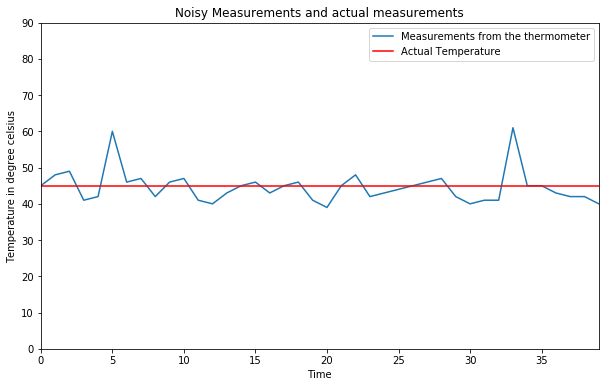

In [36]:
plt.title('Noisy Measurements and actual measurements')
plt.ylabel('Temperature in degree celsius')
plt.xlabel('Time')
plt.plot(measurement,label = 'Measurements from the thermometer')
plt.hold(True)
plt.axhline(y=actual, color='r', linestyle='-',label = 'Actual Temperature')
plt.axis([0,len(measurement)-1,0,90])
plt.legend()
plt.show()

Now let's run the code for the Kalman Filtering process.

In [4]:
initial_estimate = 60 # actually this can be anything 
initial_error_estimate = 2
error_in_measurement = 4
current_estimate = initial_estimate
current_error_estimate = initial_error_estimate
kalman_output_list = []
kalman_output_list.append(initial_estimate)
for i in range(len(measurement)):
    
    
  ####################################
  # Step 1 , calculate the Kalman Gain.
  
    kalman_gain = (current_error_estimate)/(current_error_estimate + error_in_measurement)
  ####################################
  # Step 2 , calculate the estimate at time 't' from the measurement and estimate at time 't-1'
    kalman_output = (current_estimate + (kalman_gain)*(measurement[i] - current_estimate))

    kalman_output_list.append(kalman_output)
    
    
  ####################################
  # Step 3 , calculate the error estimate at time 't'
    new_error_estimate = (1-kalman_gain)*(current_error_estimate)
    
    
  ##############################################
  # make the previous variables the current variables for the next iteration
    current_estimate = kalman_output
    current_error_estimate = new_error_estimate
  ##############################################
  

Now we have the Kalman Filters output with us.

Lets finally plot them and check our results.

/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


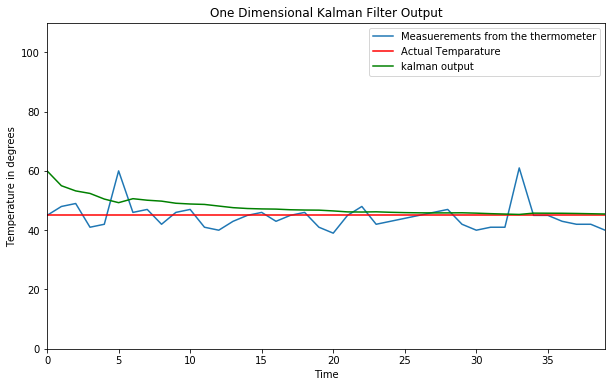

In [5]:
plt.title('One Dimensional Kalman Filter Output')
plt.xlabel('Time')
plt.ylabel('Temperature in degrees')
plt.plot(measurement,label = 'Measuerements from the thermometer')
plt.axhline(y=actual, color='r', linestyle='-',label = 'Actual Temparature')
plt.hold(True)
plt.plot(kalman_output_list,'-g',label = 'kalman output')
plt.axis([0,len(measurement)-1,0,110])
plt.legend()
plt.show()

Now that we are done with the one dimensional Kalman Filters , lets move on to the multi-dimensional case

![alt text](https://www.hdm-stuttgart.de/~maucher/Python/ComputerVision/html/_images/balltracking.png)

The following code demonstrates tracking of a ball,rolling across the scene with the help of Kalman Filter algorithm used for object tracking

### Here are the required imports

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

### Note : Please download the video from this link since we will be using it for our code , also ensure that it is in the same directory as this notebook
The video, which contains the tracking scenario is singleball.mov. This file is imported using opencv’s VideoCapture class.
You can use this link for downloading the video !!!!!

https://www.hdm-stuttgart.de/~maucher/Python/ComputerVision/html/files/singleball.mov

In [7]:
! wget https://www.hdm-stuttgart.de/~maucher/Python/ComputerVision/html/files/singleball.mov

--2018-07-10 12:35:45--  https://www.hdm-stuttgart.de/~maucher/Python/ComputerVision/html/files/singleball.mov
Resolving www.hdm-stuttgart.de (www.hdm-stuttgart.de)... 141.62.1.59, 141.62.1.53, 64:ff9b::8d3e:135, ...
Connecting to www.hdm-stuttgart.de (www.hdm-stuttgart.de)|141.62.1.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5191 (5.1K) [video/quicktime]
Saving to: ‘singleball.mov.1’

singleball.mov.1    100%[===================>]   5.07K  --.-KB/s    in 0s      

2018-07-10 12:35:46 (73.1 MB/s) - ‘singleball.mov.1’ saved [5191/5191]



 Let us see the video first 


In [8]:
import cv2
import matplotlib.pyplot as plt 
file = "singleball.mov"
cap = cv2.VideoCapture(file)
ret = True
while(ret):
    ret,frame = cap.read()
    if(ret == True):
        cv2.imshow("Original Video",frame)
        cv2.waitKey(100)    ## The next frame will be ahown after 100 milliseconds
    else:
        break
cv2.destroyAllWindows()
numframes=cap.get(7)
print (" Number of Frames in the video: ",numframes) ## It should print 45

 Number of Frames in the video:  45.0


### A matplotlib figure is initialized. Within the following loop for each frame the location of the detected object will be plotted into this figure:

/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


[0, 480.0, 360.0, 0]

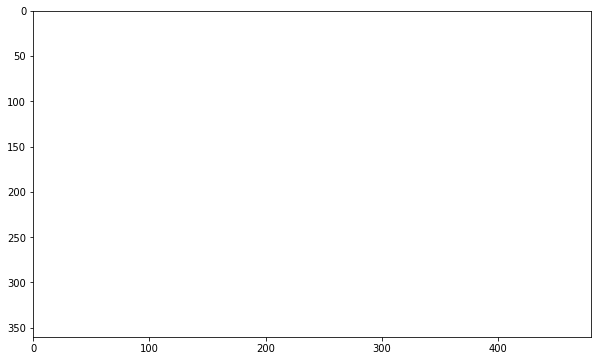

In [9]:
plt.figure()
plt.hold(True)
plt.axis([0,cap.get(3),cap.get(4),0])

[[ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ 13.375      273.0625    ]
 [ 33.15625    267.125     ]
 [ 60.04347826 264.47826087]
 [ 84.48571429 263.22857143]
 [108.59375    259.3125    ]
 [128.03030303 255.3030303 ]
 [157.3125     255.9375    ]
 [169.75       254.91666667]
 [192.20588235 255.11764706]
 [210.19354839 250.96774194]
 [229.55       246.25      ]
 [253.45833333 245.58333333]
 [266.87096774 247.87096774]
 [283.         246.9375    ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [400.17948718 246.66666667]
 [409.9       

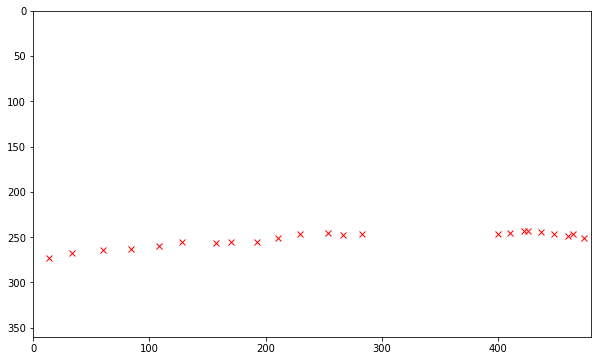

In [10]:
count = 0   # for counting the number of frames
cap = cv2.VideoCapture(file)
bgs = cv2.createBackgroundSubtractorMOG2()
# Let us make an array for storing the values of (x,y) co-ordinates of the ball
# If the ball is not visible in the frame then keep that row as [-1.0,-1.0]
# Thus lets initialize the array with rows of [-1.0 , -1.0]
measuredTrack=np.zeros((int(numframes),2))-1
while count<(numframes):
    count+=1
    ret,img2 = cap.read()
    cv2.imshow("Video",img2)
    cv2.namedWindow("Video",cv2.WINDOW_NORMAL)
    foremat=bgs.apply(img2,learningRate = 0.01)
    cv2.waitKey(20)
    ret,thresh = cv2.threshold(foremat,220,255,0)
    im2 , contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #print(len(contours))  ## This prints the number of contours (foreground objects detected)
    if len(contours) > 0:
        for i in range(len(contours)):
            area = cv2.contourArea(contours[i])  ## Calculates the Area of contours
            if area > 100: ## We check this because the area of the ball is bigger than 100 and we want to plot that only
                m= np.mean(contours[i],axis=0) ### mean is taken for finding the centre of the contour (ball in this case)
                measuredTrack[count-1,:]=m[0] 
                plt.plot(m[0,0],m[0,1],'xr')
    cv2.imshow('Foreground',foremat)
    cv2.namedWindow("Foreground",cv2.WINDOW_NORMAL)
    cv2.waitKey(80)
cap.release()
cv2.destroyAllWindows()
print(measuredTrack)
### save the trajectory of the ball in a numpy file , so that it can be used
### later to be passed as an input to the Kalman Filter process.
np.save("ballTrajectory", measuredTrack)   
plt.axis((0,480,360,0))
plt.show()

 The following loop iterates over all frames of the video sequence.
 
 Each frame is plotted to the opencv figure video. Then the apply()-method of the background subtractor instance is called, this method returns a foreground mask for the current frame.
 
 By applying a threshold to the foreground mask it is converted into a binary image, containing 1 at all pixels which belong to the foreground and 0 at all pixels belonging to background. An area of connected foreground pixels is a foreground object.

 The contours of foreground objects can be determined by applying opencv’s findContours() function. In general there can exist more than one foreground objects and corresponding contours in a frame. 

## Explaination of the above code :
1)      The centroid of the contour is assumed to be the location of the foreground object.

 2)      This location is tracked for each frame. The location is plotted into the matplotlib figure.
 
3)      Moreover, for each frame the location of the tracked object is stored in the numpy array measuredTrack. 

 4)      Finally the numpy array measuredTrack is stored to a file. The contents of this file (i.e. the measured track) constitute the input for the Kalman Filter. The Kalman Filter is implemented in another python module (see Kalman Filter ) and provides a more accurate track of the moving object.:

#### The track measured above shall be refined by Kalman filtering. 
 Even though a Kalman Filter is implemented in opencv, we apply the Kalman Filter module pykalman due to its better documentation.

So lets install pykalman first.

In [11]:
! pip install pykalman

    100% |████████████████████████████████| 235kB 2.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for pykalman ... done
  Stored in directory: /home/unnikrishnan/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman
flickr-download 0.2.19 has requirement python-dateutil==1.5, but you'll have python-dateutil 2.7.3 which is incompatible.


###  Import the"KalmanFilter" library from this amazing module 

In [12]:
from pykalman import KalmanFilter

### Load the saved "ballTrajectory.npy" file 

In [13]:
Measured = np.load("ballTrajectory.npy")

In [14]:
Measured.shape  ## It should print (number of frames , 2)

(45, 2)

In [15]:
Measured

array([[ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ 13.375     , 273.0625    ],
       [ 33.15625   , 267.125     ],
       [ 60.04347826, 264.47826087],
       [ 84.48571429, 263.22857143],
       [108.59375   , 259.3125    ],
       [128.03030303, 255.3030303 ],
       [157.3125    , 255.9375    ],
       [169.75      , 254.91666667],
       [192.20588235, 255.11764706],
       [210.19354839, 250.96774194],
       [229.55      , 246.25      ],
       [253.45833333, 245.58333333],
       [266.87096774, 247.87096774],
       [283.        , 246.9375    ],
       [ -1.        ,  -1.        ],
 

 Remove the First part of the video from the Measured array when the ball was not there in the video.
 
 So we need to remove all the rows of [ -1.0,-1.0 ] untill the first measurement is recorded (the time when the ball enters the video)
 
 If you noticed closely the ball enters in the video sometime after the video starts

In [16]:
while True:
   if Measured[0,0]==-1.:
       Measured=np.delete(Measured,0,0)
   else:
       break
numMeas=Measured.shape[0]

In [17]:
Measured

array([[ 13.375     , 273.0625    ],
       [ 33.15625   , 267.125     ],
       [ 60.04347826, 264.47826087],
       [ 84.48571429, 263.22857143],
       [108.59375   , 259.3125    ],
       [128.03030303, 255.3030303 ],
       [157.3125    , 255.9375    ],
       [169.75      , 254.91666667],
       [192.20588235, 255.11764706],
       [210.19354839, 250.96774194],
       [229.55      , 246.25      ],
       [253.45833333, 245.58333333],
       [266.87096774, 247.87096774],
       [283.        , 246.9375    ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [ -1.        ,  -1.        ],
       [400.17948718, 246.66666667],
       [409.9       , 245.4       ],
       [421.89655172, 243.65517241],
       [425.86792453, 243.18867925],
       [436.95081967, 244.45901639],
       [447.8       , 246.43333333],
 

However as you can clearly see there are some parts of this array still have the  [-1.0 , -1.0] rows left
 
These indicate the parts of the video where the ball was inside the box and also the parts of the video after the ball is gone completely out of the vision

 By applying Numpy Masked Arrays these positions without measurement can be particullarly marked and the following Kalman Filter module is able to interprete these positions as missing-measurement position.:
 
 
Thus at these positions we can use the help of the Kalman FIlter algorithm to predict the position of the ball even when it is behind the box or even out of the video completely !!!!

In [18]:
MarkedMeasure=np.ma.masked_less(Measured,0)

In [19]:
MarkedMeasure

masked_array(
  data=[[13.375, 273.0625],
        [33.15625, 267.125],
        [60.04347826086956, 264.4782608695652],
        [84.48571428571428, 263.22857142857146],
        [108.59375, 259.3125],
        [128.03030303030303, 255.3030303030303],
        [157.3125, 255.9375],
        [169.75, 254.91666666666666],
        [192.2058823529412, 255.11764705882354],
        [210.19354838709677, 250.96774193548387],
        [229.55, 246.25],
        [253.45833333333334, 245.58333333333334],
        [266.8709677419355, 247.8709677419355],
        [283.0, 246.9375],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [400.1794871794872, 246.66666666666666],
        [409.9, 245.4],
        [421.8965517241379, 243.6551724137931],
        [425.8679245283019, 243.18867924528303],
        [436.95081967213116, 244.45901639344262],
        [447.8, 246.43333333333334],
        [460.43333333333334, 249.26666666666668],
 

In this demonstration the state is modeled as a vector, containing the variables

 x-coordinate of current position: x
 
y-coordinate of current position: y

current speed in x-direction: vx

current speed in y-direction: vy



#### The measured parameters are x and y. Thus the transition matrix (process model) and the observation matrix (measurement model) are:

In [20]:
Transition_Matrix=[[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]]  # A matrix
Observation_Matrix=[[1,0,0,0],[0,1,0,0]] # H matrix

#### Besides these two models the Kalman Filter requires:

 1)     an initial state, defined by xinit,yinit,vxinit,vyinit

 2)     an initial state covariance initstatecovariance, which describes the certainty of the initial state.

3)     a transition covariance, which describes the certainty of the process model.

4)     a observation covariance, which describes the certainty of the measurement model.:

In [21]:
xinit=MarkedMeasure[0,0] ## First Measurement of x-coord
yinit=MarkedMeasure[0,1] ## First Measurement of y-coord
vxinit=MarkedMeasure[1,0]-MarkedMeasure[0,0] ## as v = (d_1 - d_0)/(time)
vyinit=MarkedMeasure[1,1]-MarkedMeasure[0,1] 
initstate=[xinit,yinit,vxinit,vyinit]
initcovariance=1.0e-3*np.eye(4) 
transistionCov=1.0e-4*np.eye(4)
observationCov=1.0e-1*np.eye(2)
kf=KalmanFilter(transition_matrices=Transition_Matrix,
            observation_matrices =Observation_Matrix,
            initial_state_mean=initstate,
            initial_state_covariance=initcovariance,
            transition_covariance=transistionCov,
            observation_covariance=observationCov)

By calling the filter()-method of the KalmanFilter object the track (filtered_mean_state) and its certainty in form of filtered_state_covariances are computed.

## The resulting track is plotted to a matplotlib-figure, which is shown below.:

/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/home/unnikrishnan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes a

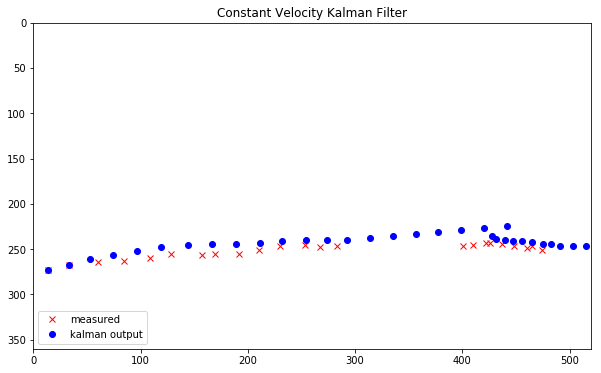

In [22]:
(filtered_state_means, filtered_state_covariances) = kf.filter(MarkedMeasure)
plt.plot(MarkedMeasure[:,0],MarkedMeasure[:,1],'xr',label='measured')
plt.axis([0,520,360,0])
plt.hold(True)
plt.plot(filtered_state_means[:,0],filtered_state_means[:,1],'ob',label='kalman output')
plt.hold(True)
plt.legend(loc=3)
plt.title("Constant Velocity Kalman Filter")
plt.show()

### Kalman Filtering based Cam-shift Object tracking

---



Let me run the code on the laptop first and show you how it works.

After that we will see how to write such codes. We will analyse the code step by step

In [35]:
#####################################################################

keep_processing = True;
camera_to_use = 0; # 0 if you have one camera, 1 or > 1 otherwise

selection_in_progress = False; # support interactive region selection

#####################################################################

Let us write a function which will help us in selecting the object we want to track

In [36]:
#############################################################

# select a region using the mouse

boxes = [];
current_mouse_position = np.ones(2, dtype=np.int32);

def on_mouse(event, x, y, flags, params):

    global boxes;
    global selection_in_progress;

    current_mouse_position[0] = x;
    current_mouse_position[1] = y;

    if event == cv2.EVENT_LBUTTONDOWN:
        boxes = [];
        # print 'Start Mouse Position: '+str(x)+', '+str(y)
        sbox = [x, y];
        selection_in_progress = True;
        boxes.append(sbox);

    elif event == cv2.EVENT_LBUTTONUP:
        # print 'End Mouse Position: '+str(x)+', '+str(y)
        ebox = [x, y];
        selection_in_progress = False;
        boxes.append(ebox);
#####################################################################

Now a small function to return centre of a set of points representing a rectangle

In [37]:
#####################################################################
def center(points):
    x = (points[0][0] + points[1][0] + points[2][0] + points[3][0]) / 4.0
    y = (points[0][1] + points[1][1] + points[2][1] + points[3][1]) / 4.0
    return np.array([np.float32(x), np.float32(y)], np.float32)

#####################################################################

In [38]:
####################################################################

# this function is called as a call-back everytime the trackbar is moved
# (here we just do nothing)

def nothing(x):
    pass

#####################################################################
# define video capture object

cap = cv2.VideoCapture(0)

# define display window name

windowName = "Kalman Object Tracking" # window name
windowName2 = "Hue histogram back projection" # window name
windowNameSelection = "initial selected region"


Ok now enough of User Interface handling 

Let's get to the main Kalman filtering and Camshift part of the code.

First let us initialize all the Matrices of our Kalman Filter model

In [39]:
kalman = cv2.KalmanFilter(4,2)
kalman.measurementMatrix = np.array([[1,0,0,0],
                                     [0,1,0,0]],np.float32)  

kalman.transitionMatrix = np.array([[1,0,1,0],
                                    [0,1,0,1],
                                    [0,0,1,0],
                                    [0,0,0,1]],np.float32) 

kalman.processNoiseCov = np.array([[1,0,0,0],
                                   [0,1,0,0],
                                   [0,0,1,0],
                                   [0,0,0,1]],np.float32) * 0.03

measurement = np.array((2,1), np.float32)
prediction = np.zeros((2,1), np.float32)

In [40]:
# if command line arguments are provided try to read video_name
# otherwise default to capture from the webcam of your laptop
import sys
import math
if (((len(sys.argv) == 2) and (cap.open(str(sys.argv[1]))))
    or (cap.open(camera_to_use))):

    # create window by name (note flags for resizable or not)

    cv2.namedWindow(windowName, cv2.WINDOW_NORMAL);
    cv2.namedWindow(windowName2, cv2.WINDOW_NORMAL);
    cv2.namedWindow(windowNameSelection, cv2.WINDOW_NORMAL);

    # set sliders for HSV selection thresholds

    s_lower = 60;
    cv2.createTrackbar("s lower", windowName2, s_lower, 255, nothing)
    s_upper = 255;
    cv2.createTrackbar("s upper", windowName2, s_upper, 255, nothing)
    v_lower = 32;
    cv2.createTrackbar("v lower", windowName2, v_lower, 255, nothing)
    v_upper = 255;
    cv2.createTrackbar("v upper", windowName2, v_upper, 255, nothing)

    # set a mouse callback

    cv2.setMouseCallback(windowName, on_mouse, 0)
    cropped = False

    # Setup the termination criteria for search, either 10 iteration or
    # move by at least 1 pixel pos. difference
    term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

    while (keep_processing):

        # if video file successfully opens then read frame from video

        if (cap.isOpened):
            ret, frame = cap.read();

        # start a timer (to see how long processing and display takes)

        start_t = cv2.getTickCount();

        # get parameters from track bars

        s_lower = cv2.getTrackbarPos("s lower", windowName2);
        s_upper = cv2.getTrackbarPos("s upper", windowName2);
        v_lower = cv2.getTrackbarPos("v lower", windowName2);
        v_upper = cv2.getTrackbarPos("v upper", windowName2);

        # select region using the mouse and display it

        if (len(boxes) > 1) :
            crop = frame[boxes[0][1]:boxes[1][1],boxes[0][0]:boxes[1][0]].copy() # This crop variable is our image 
                                                                                 # of the selected region

            h, w, c = crop.shape;   # size of template
            if (h > 0) and (w > 0):
                cropped = True;

                # convert region to HSV

                hsv_crop =  cv2.cvtColor(crop, cv2.COLOR_BGR2HSV);

                # select all Hue (0-> 180) and Sat. values but eliminate values with very low
                # saturation or value (due to lack of useful colour information)

                mask = cv2.inRange(hsv_crop, np.array((0., float(s_lower),float(v_lower))), np.array((180.,float(s_upper),float(v_upper))));
                # mask = cv2.inRange(hsv_crop, np.array((0., 60.,32.)), np.array((180.,255.,255.)));

                # construct a histogram of hue and saturation values and normalize it

                crop_hist = cv2.calcHist([hsv_crop],[0, 1],mask,[180, 255],[0,180, 0, 255])
                cv2.normalize(crop_hist,crop_hist,0,255,cv2.NORM_MINMAX)

                # set intial position of object
                
                track_window = (boxes[0][0],boxes[0][1],boxes[1][0] - boxes[0][0],boxes[1][1] - boxes[0][1]);
                ####  track_window has (ix,iy,w,h)
                 
                cv2.imshow(windowNameSelection,crop);

            # reset list of boxes

            boxes = [];

        # interactive display of selection box
        # Make a green colour boundary around the selected object.
        if (selection_in_progress):
            top_left = (boxes[0][0], boxes[0][1]);
            bottom_right = (current_mouse_position[0], current_mouse_position[1]);
            cv2.rectangle(frame,top_left, bottom_right, (0,0,255), 2);

        # if we have a selected region

        if (cropped):

            # convert the entire incoming image to HSV.

            img_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV);

            # back projection of histogram based on Hue and Saturation only

            img_bproject = cv2.calcBackProject([img_hsv],[0,1],crop_hist,[0,180,0,255],1);
            cv2.imshow(windowName2,img_bproject);

            # apply camshift to predict new location (observation)
            # basic HSV histogram comparision with adaptive window size
            # see : http://docs.opencv.org/3.1.0/db/df8/tutorial_py_meanshift.html
            ret, track_window = cv2.CamShift(img_bproject, track_window, term_crit);

            # draw observation on image
            x,y,w,h = track_window;
            frame = cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0),2);
            # The main observation is of blur colour.
            
            # extract centre of this observation as points
            pts = cv2.boxPoints(ret)
            pts = np.int0(pts)
            # (cx, cy), radius = cv2.minEnclosingCircle(pts)

            # use to correct kalman filter

            kalman.correct(center(pts));

            # get new kalman filter prediction

            prediction = kalman.predict();

            # draw predicton on image

            frame = cv2.rectangle(frame, (prediction[0]-(0.5*w),prediction[1]-(0.5*h)), (prediction[0]+(0.5*w),prediction[1]+(0.5*h)), (0,255,0),2);

        else:

            # before we have cropped anything show the mask we are using
            # for the S and V components of the HSV image

            img_hsv =  cv2.cvtColor(frame, cv2.COLOR_BGR2HSV);

            # select all Hue values (0-> 180) but eliminate values with very low
            # saturation or value (due to lack of useful colour information)

            mask = cv2.inRange(img_hsv, np.array((0., float(s_lower),float(v_lower))), np.array((180.,float(s_upper),float(v_upper))));

            cv2.imshow(windowName2,mask);

        # display image

        cv2.imshow(windowName,frame);

        # stop the timer and convert to ms. (to see how long processing and display takes)

        stop_t = ((cv2.getTickCount() - start_t)/cv2.getTickFrequency()) * 1000;

        # start the event loop - essential

        # cv2.waitKey() is a keyboard binding function (argument is the time in milliseconds).
        # It waits for specified milliseconds for any keyboard event.
        # If you press any key in that time, the program continues.
        # If 0 is passed, it waits indefinitely for a key stroke.
        # (bitwise and with 0xFF to extract least significant byte of multi-byte response)
        # here we use a wait time in ms. that takes account of processing time already used in the loop

        # wait 40ms or less depending on processing time taken (i.e. 1000ms / 25 fps = 40 ms)

        key = cv2.waitKey(max(2, 40 - int(math.ceil(stop_t)))) & 0xFF;

        # It can also be set to detect specific key strokes by recording which key is pressed

        # e.g. if user presses "x" then exit

        if (key == 27):
            keep_processing = False;

    # close all windows

    cv2.destroyAllWindows()
    cap.release()

else:
    print("No video file specified or camera connected.");

#####################################################################

We would also like you to go through this amazing paper which uses Kalman Filtering Based Camshift Object Tracking.

http://www.naturalspublishing.com/files/published/u956oro5157k5y.pdf

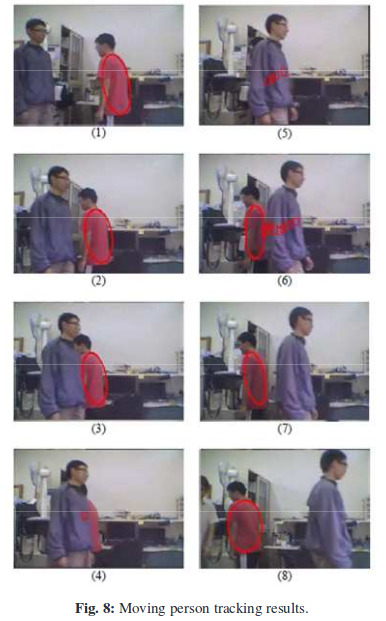

In [41]:
from IPython.core.display import Image 
Image(filename='/home/unnikrishnan/Paper_result.jpeg')

The   Kalman   filter   can   provide  the   estimated positions  continuously.

Finally  the  estimation  position will  be  the  initial  position  of  CamShift  when  the  target appears  again. 

In  this  case,  the  target  is  occluded  in  8 frames,   and   the   Kalman   filter   provides   the   possible
positions. 

The  square  marks  in  (4)  -  (6)  are  the estimated  positions  made  by  Kalman  filter.

When  the target  appears  again,  the  CamShift  will  catch  the  target immediately based on the estimated positions. 

# That's the end of the session

# $Cheers$
# $CVI~Team$

# $IIT~Madras$